In [4]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [5]:
import keras
print(keras.__version__)

3.4.1


In [6]:
from keras import applications
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.layers import Input, Convolution2D, MaxPool2D, Activation, Dense, Flatten, Dropout
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

import matplotlib.pyplot as plt
from PIL import Image

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import os
from pathlib import Path
from datetime import datetime

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())



[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17826578719650924240
xla_global_id: -1
]


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Read Images

train_path = "gdrive/MyDrive/CatsAndDogs/train"
test_path = "gdrive/MyDrive/CatsAndDogs/test1"

train_images = Path(train_path).glob ("*.jpg")
test_images = Path(test_path).glob( "*.jpg")
train_images = list(train_images)
test_images = list(test_images)
num_train = len(train_images)
num_test = len(test_images)
print(num_train)
print(num_test)


12823
12510


In [ ]:
train_set =[]

for file in train_images:
  fileName = os.path.basename(file)
  #img = Image.open (file)
  label = fileName.split(".")[0]
  train_set.append([fileName, label])

print(train_set[5])
train_df = pd.DataFrame(train_set, columns=['Image', 'Class'])
train_df['Class'].value_counts()
#train_df.head()


['cat.9384.jpg', 'cat']


,count
Class,
cat,12500
dog,323


In [ ]:
# Image size
img_width, img_height, img_depth = 128, 128, 3


In [ ]:
# Training parameters
epochs = 10
batch_size = 32
freq = 25
num_classes = 2
train_valid_split = 0.2
nb_train_samples = int(len(train_images) * (1-train_valid_split))
nb_valid_samples = len(train_images) - nb_train_samples

class_weights = {0: 1.,
                1: 2.}

if num_classes < 2:
    act_type = 'sigmoid'
    class_mode = 'binary'
    loss_fun = 'binary_crossentropy'
else:
    act_type = 'softmax'
    class_mode = 'categorical'
    loss_fun = 'categorical_crossentropy'

print('Type of classification: ', class_mode)
print('Loss function: ', loss_fun)
print('Activation function: ', act_type)

Type of classification:  categorical
Loss function:  categorical_crossentropy
Activation function:  softmax


In [ ]:
# ImageDataGenerator

df_train, df_valid = train_test_split(train_df, test_size=train_valid_split, random_state=1)

datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    fill_mode = 'constant')

train_generator = datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = train_path,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'Class',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

valid_generator = datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = train_path,
    target_size = (img_width, img_height),
    x_col = 'Image',
    y_col = 'Class',
    class_mode = class_mode,
    color_mode = 'rgb',
    batch_size = batch_size,
    shuffle = True)

train_generator.class_indices



Found 10258 validated image filenames belonging to 2 classes.
Found 2565 validated image filenames belonging to 2 classes.


{'cat': 0, 'dog': 1}

In [ ]:
# Build Model
image_input = Input(shape = (img_width, img_height, img_depth))
base_model = applications.vgg16.VGG16(input_tensor = image_input,
                                 include_top = False,
                                 weights = 'imagenet')

print(base_model.layers[-1].name)
base_output = base_model.layers[-1].output


flat1 = Flatten()(base_output)
fc1 = Dense(8192, activation = 'relu')(flat1)
dropfc1 = Dropout(0.5)(fc1)
fc2 = Dense(4096, activation = 'relu')(dropfc1)
dropfc2 = Dropout(0.5)(fc2)

output = Dense(num_classes, activation = act_type)(dropfc2)

for layer in base_model.layers:
    layer.trainable = False

model = Model(image_input, output)
print(image_input.shape)
print(base_output.shape)
print(output.shape)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
block5_pool
(None, 128, 128, 3)
(None, 4, 4, 512)
(None, 2)


In [ ]:
from pickle import TRUE
# Compile the model
opt = Adam(learning_rate= 0.001)
model.compile(loss = loss_fun, optimizer = opt, metrics = ['accuracy'])
model.summary(show_trainable= TRUE)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer (InputLayer)            │ (None, 128, 128, 3)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv1 (Conv2D)               │ (None, 128, 128, 64)         │         1,792 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_conv2 (Conv2D)               │ (None, 128, 128, 64)         │        36,928 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block1_pool (MaxPooling2D)          │ (None, 64, 64, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv1 (Conv2D)               │ (None, 64, 64, 128)          │        73,856 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_conv2 (Conv2D)               │ (None, 64, 64, 128)          │       147,584 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block2_pool (MaxPooling2D)          │ (None, 32, 32, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv1 (Conv2D)               │ (None, 32, 32, 256)          │       295,168 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv2 (Conv2D)               │ (None, 32, 32, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_conv3 (Conv2D)               │ (None, 32, 32, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block3_pool (MaxPooling2D)          │ (None, 16, 16, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv1 (Conv2D)               │ (None, 16, 16, 512)          │     1,180,160 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv2 (Conv2D)               │ (None, 16, 16, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_conv3 (Conv2D)               │ (None, 16, 16, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block4_pool (MaxPooling2D)          │ (None, 8, 8, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv1 (Conv2D)               │ (None, 8, 8, 512)            │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv2 (Conv2D)               │ (None, 8, 8, 512)            │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_conv3 (Conv2D)               │ (None, 8, 8, 512)            │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ block5_pool (MaxPooling2D)          │ (None, 4, 4, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ flatten (Flatten)    

 Total params: 115,398,466 (440.21 MB)

 Trainable params: 100,683,778 (384.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

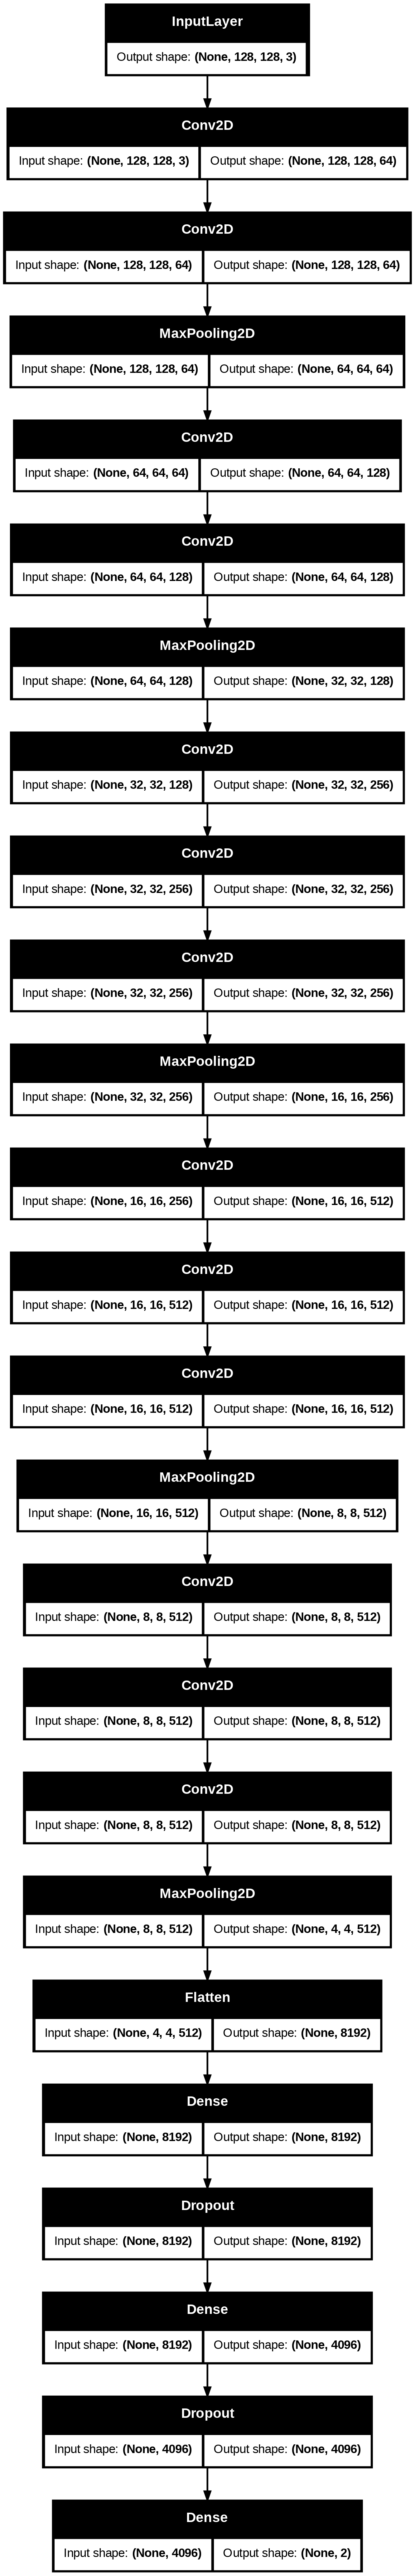

In [ ]:
# Folder setup
init_time = datetime.now()
fold_num = 1
current_time = init_time.strftime('%Y%m%d_%H%M%S')
name_dir = 'gdrive/MyDrive/MidTerm/Classifier/trained_models_' + current_time + '_fold_num' + str(fold_num)
os.mkdir(name_dir)

# Callbacks1: ModelCheckpointer
model_file_format = name_dir + '/model_' + str(fold_num) + '_model.{epoch:04d}.keras'
check = ModelCheckpoint(model_file_format, save_freq = freq, verbose = 1)

# Callbacks2: TensorBoard
tensor_check = './logs/' + current_time + '_train_testsplit' + str(fold_num)
tensor_board = TensorBoard(tensor_check)

# Callbacks3: EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')
# Plot model
figure_name = name_dir + '/model_output.png'
plot_model(model, figure_name, show_shapes = TRUE)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


24/25 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - accuracy: 0.8701 - loss: 9.8708 
Epoch 1: saving model to gdrive/MyDrive/MidTerm/Classifier/trained_models_20241101_230023_fold_num1/model_1_model.0001.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - accuracy: 0.8724 - loss: 9.7032 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 599s 19s/step - accuracy: 0.8746 - loss: 9.5484 - val_accuracy: 0.9688 - val_loss: 0.3013
Epoch 2/10
24/25 ━━━━━━━━━━━━━━━━━━━━ 13s 14s/step - accuracy: 0.9168 - loss: 0.6564
Epoch 2: saving model to gdrive/MyDrive/MidTerm/Classifier/trained_models_20241101_230023_fold_num1/model_1_model.0002.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 401s 17s/step - accuracy: 0.9181 - loss: 0.6491 - val_accuracy: 0.9750 - val_loss: 0.1855
Epoch 3/10
24/25 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9517 - loss: 0.5283
Epoch 3: saving model to gdrive/MyDrive/MidTerm/Classifier/trained_models_20241101_230023_fold_num1/model_1_model.0003.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 315s 13s/step - accuracy: 0.9511 - loss: 0.5281 - val_accuracy: 0.9812 - val_loss: 0.1849
Epoch 4/10
24/25 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.9778 - loss: 0.2712
Epoch 4: saving model to gdrive/MyDrive/MidTerm/Classifier/trained_models_20241101_230023_fold_num1/model_1_model.0004.keras
25/25 ━━━━━━━━━━━━━

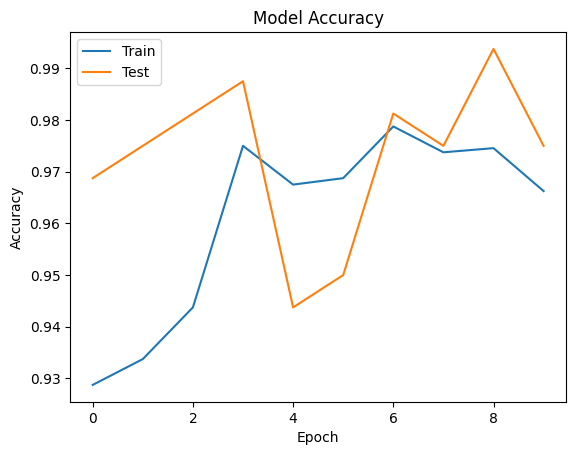

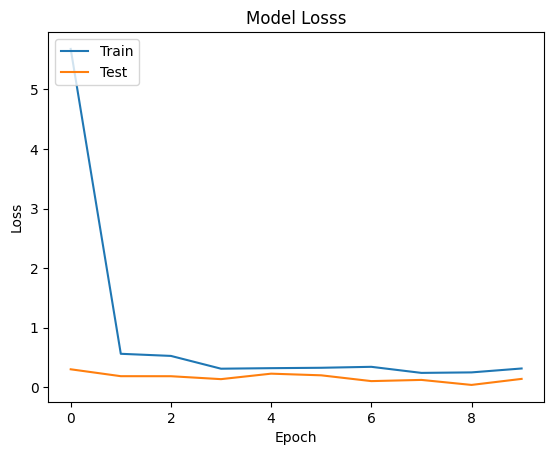

In [ ]:
history2 = model.fit(train_generator,
                              epochs = 10,
                              steps_per_epoch = 25,
                              validation_data = valid_generator,
                              validation_steps = 5,
                              callbacks = [check, tensor_board, early_stop],
                              class_weight = class_weights)

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model Losss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

early_stop_name = '/fold_num_earlystop' + str(fold_num) + 'early_stop_model.weights.h5'
model.save_weights(early_stop_name)